In [1]:
import os
opj = os.path.join

#os.environ["OMP_NUM_THREADS"] = "6"  # export OMP_NUM_THREADS=4
#os.environ["OPENBLAS_NUM_THREADS"] = "6"  # export OPENBLAS_NUM_THREADS=4
#os.environ["MKL_NUM_THREADS"] = "6"  # export MKL_NUM_THREADS=6
#os.environ["VECLIB_MAXIMUM_THREADS"] = "6"  # export VECLIB_MAXIMUM_THREADS=4
#os.environ["NUMEXPR_NUM_THREADS"] = "6"  # export NUMEXPR_NUM_THREADS=6
import mkl
mkl.set_num_threads(10)

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as pl
%matplotlib notebook
pl.ion()

import numpy as np
import yaml
import sys

sys.path.append("..")

from utils.utils import create_dm_from_screenshots, prepare_surface_data, prepare_volume_data
from prfpy.stimulus import PRFStimulus2D
from prfpy.grid import Iso2DGaussianGridder, Norm_Iso2DGaussianGridder, DoG_Iso2DGaussianGridder
from prfpy.fit import Iso2DGaussianFitter, Norm_Iso2DGaussianFitter, DoG_Iso2DGaussianFitter

Using TensorFlow backend.


In [2]:
subj = 'sub-001'
analysis_settings = '/Users/marcoaqil/prfpy_norm/analysis_settings.yml'

with open(analysis_settings) as f:
    analysis_info = yaml.safe_load(f)

# note that screenshot paths and task names should be in the same order
n_pix = analysis_info["n_pix"]
discard_volumes = analysis_info["discard_volumes"]
screenshot_paths = analysis_info["screenshot_paths"]
screen_size_cm = analysis_info["screen_size_cm"]
screen_distance_cm = analysis_info["screen_distance_cm"]
TR = analysis_info["TR"]
task_names = analysis_info["task_names"]
data_path = analysis_info["data_path"]
fitting_space = analysis_info["fitting_space"]
window_length = analysis_info["window_length"]
n_jobs = analysis_info["n_jobs"]
hrf = analysis_info["hrf"]
gradient_method = analysis_info["gradient_method"]
verbose = analysis_info["verbose"]
rsq_threshold = analysis_info["rsq_threshold"]

if "grid_data_path" in analysis_info:
    grid_data_path = analysis_info["grid_data_path"]
else:
    grid_data_path = None
    
if "timecourse_data_path" in analysis_info:
    timecourse_data_path = analysis_info["timecourse_data_path"]
else:
    timecourse_data_path = None   


In [3]:
dm_list = []

for screenshot_path in screenshot_paths:
    # create stimulus
    dm_list.append(create_dm_from_screenshots(screenshot_path,
                                              n_pix)[..., discard_volumes:])


task_lengths = [dm.shape[-1] for dm in dm_list]


dm_full = np.concatenate(tuple(dm_list), axis=-1)

prf_stim = PRFStimulus2D(screen_size_cm=screen_size_cm,
                         screen_distance_cm=screen_distance_cm,
                         design_matrix=dm_full,
                         TR=TR)


# late-empty DM periods (for calculation of BOLD baseline)
shifted_dm = np.zeros_like(dm_full)

# number of TRs in which activity may linger (hrf)
shifted_dm[..., 7:] = dm_full[..., :-7]

late_iso_dict = {}
late_iso_dict['periods'] = np.where((np.sum(dm_full, axis=(0, 1)) == 0) & (
    np.sum(shifted_dm, axis=(0, 1)) == 0))[0]

start=0
for i, task_name in enumerate(task_names):
    stop=start+task_lengths[i]
    if task_name not in screenshot_paths[i]:
        print("WARNING: check that screenshot paths and task names are in the same order")
    late_iso_dict[task_name] = late_iso_dict['periods'][np.where((late_iso_dict['periods']>=start) & (late_iso_dict['periods']<stop))]
        
    start+=task_lengths[i]
    

Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed
Design matrix completed


In [4]:
if timecourse_data_path == None:
    if fitting_space == "fsaverage" or fitting_space == "fsnative":
    
        tc_full_iso_nonzerovar_dict = prepare_surface_data(subj,
                                                           task_names,
                                                           discard_volumes,
                                                           window_length,
                                                           late_iso_dict,
                                                           data_path,
                                                           fitting_space)
    
    else:
    
        tc_full_iso_nonzerovar_dict = prepare_volume_data(subj,
                                                          task_names,
                                                          discard_volumes,
                                                          window_length,
                                                          late_iso_dict,
                                                          data_path,
                                                          fitting_space)
else:
    #mainly for testing purposes
    tc_full_iso_nonzerovar_dict = {}
    tc_full_iso_nonzerovar_dict['tc'] = np.load(timecourse_data_path)

In [179]:
#outdated
res = np.zeros((tc_full_iso_nonzerovar_dict['orig_data_shape']['L_shape'][0]+
                tc_full_iso_nonzerovar_dict['orig_data_shape']['R_shape'][0],10))

res[tc_full_iso_nonzerovar_dict_check['nonzerovar_mask']] = gf_norm.iterative_search_params

res_L = res[:tc_full_iso_nonzerovar_dict_check['orig_data_shape']['L_shape'][0]]
res_R = res[tc_full_iso_nonzerovar_dict_check['orig_data_shape']['L_shape'][0]:]

res_R.shape
#data in make_webgl is 10 by 320k ORDER LEFT RIGHT

In [82]:
css_res = np.load('/Users/marcoaqil/PRFMapping/sub-001_CSS-iterparams_space-fsaverage.npy')
dog_res = np.load('/Users/marcoaqil/PRFMapping/sub-001_DoG-iterparams_space-fsaverage.npy')
norm_res = np.load('/Users/marcoaqil/PRFMapping/sub-001_norm-iterparams-combined_space-fsaverage.npy')

rsq_models = np.zeros((tc_full_iso_nonzerovar_dict['orig_data_shape']['L_shape'][0]+
                tc_full_iso_nonzerovar_dict['orig_data_shape']['R_shape'][0],3))

rsq_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],0] = css_res[:, -1]
rsq_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],1] = dog_res[:, -1]
rsq_models[tc_full_iso_nonzerovar_dict['nonzerovar_mask'],2] = norm_res[:, -1]

import cortex

red = cortex.Vertex(rsq_models[:, 0],
                        subject='fsaverage', vmin=0.4, vmax=0.8)
green = cortex.Vertex(rsq_models[:, 1],
                          subject='fsaverage', vmin=0.4, vmax=0.8)
blue = cortex.Vertex(rsq_models[:, 2],
                         subject='fsaverage', vmin=0.4, vmax=0.8)

#alpha = np.ones_like(rsq_models[:,0])
alpha = np.mean(rsq_models, axis=-1)/np.max(np.mean(rsq_models, axis=-1))                         

models_rsq_vertex_data = cortex.VertexRGB(red, green, blue, subject='fsaverage', alpha=alpha)

ds = cortex.Dataset(rsq=models_rsq_vertex_data)  

cortex.webgl.make_static(outpath='/Users/marcoaqil/PRFMapping', data=ds)


<IPython.core.display.Javascript object>


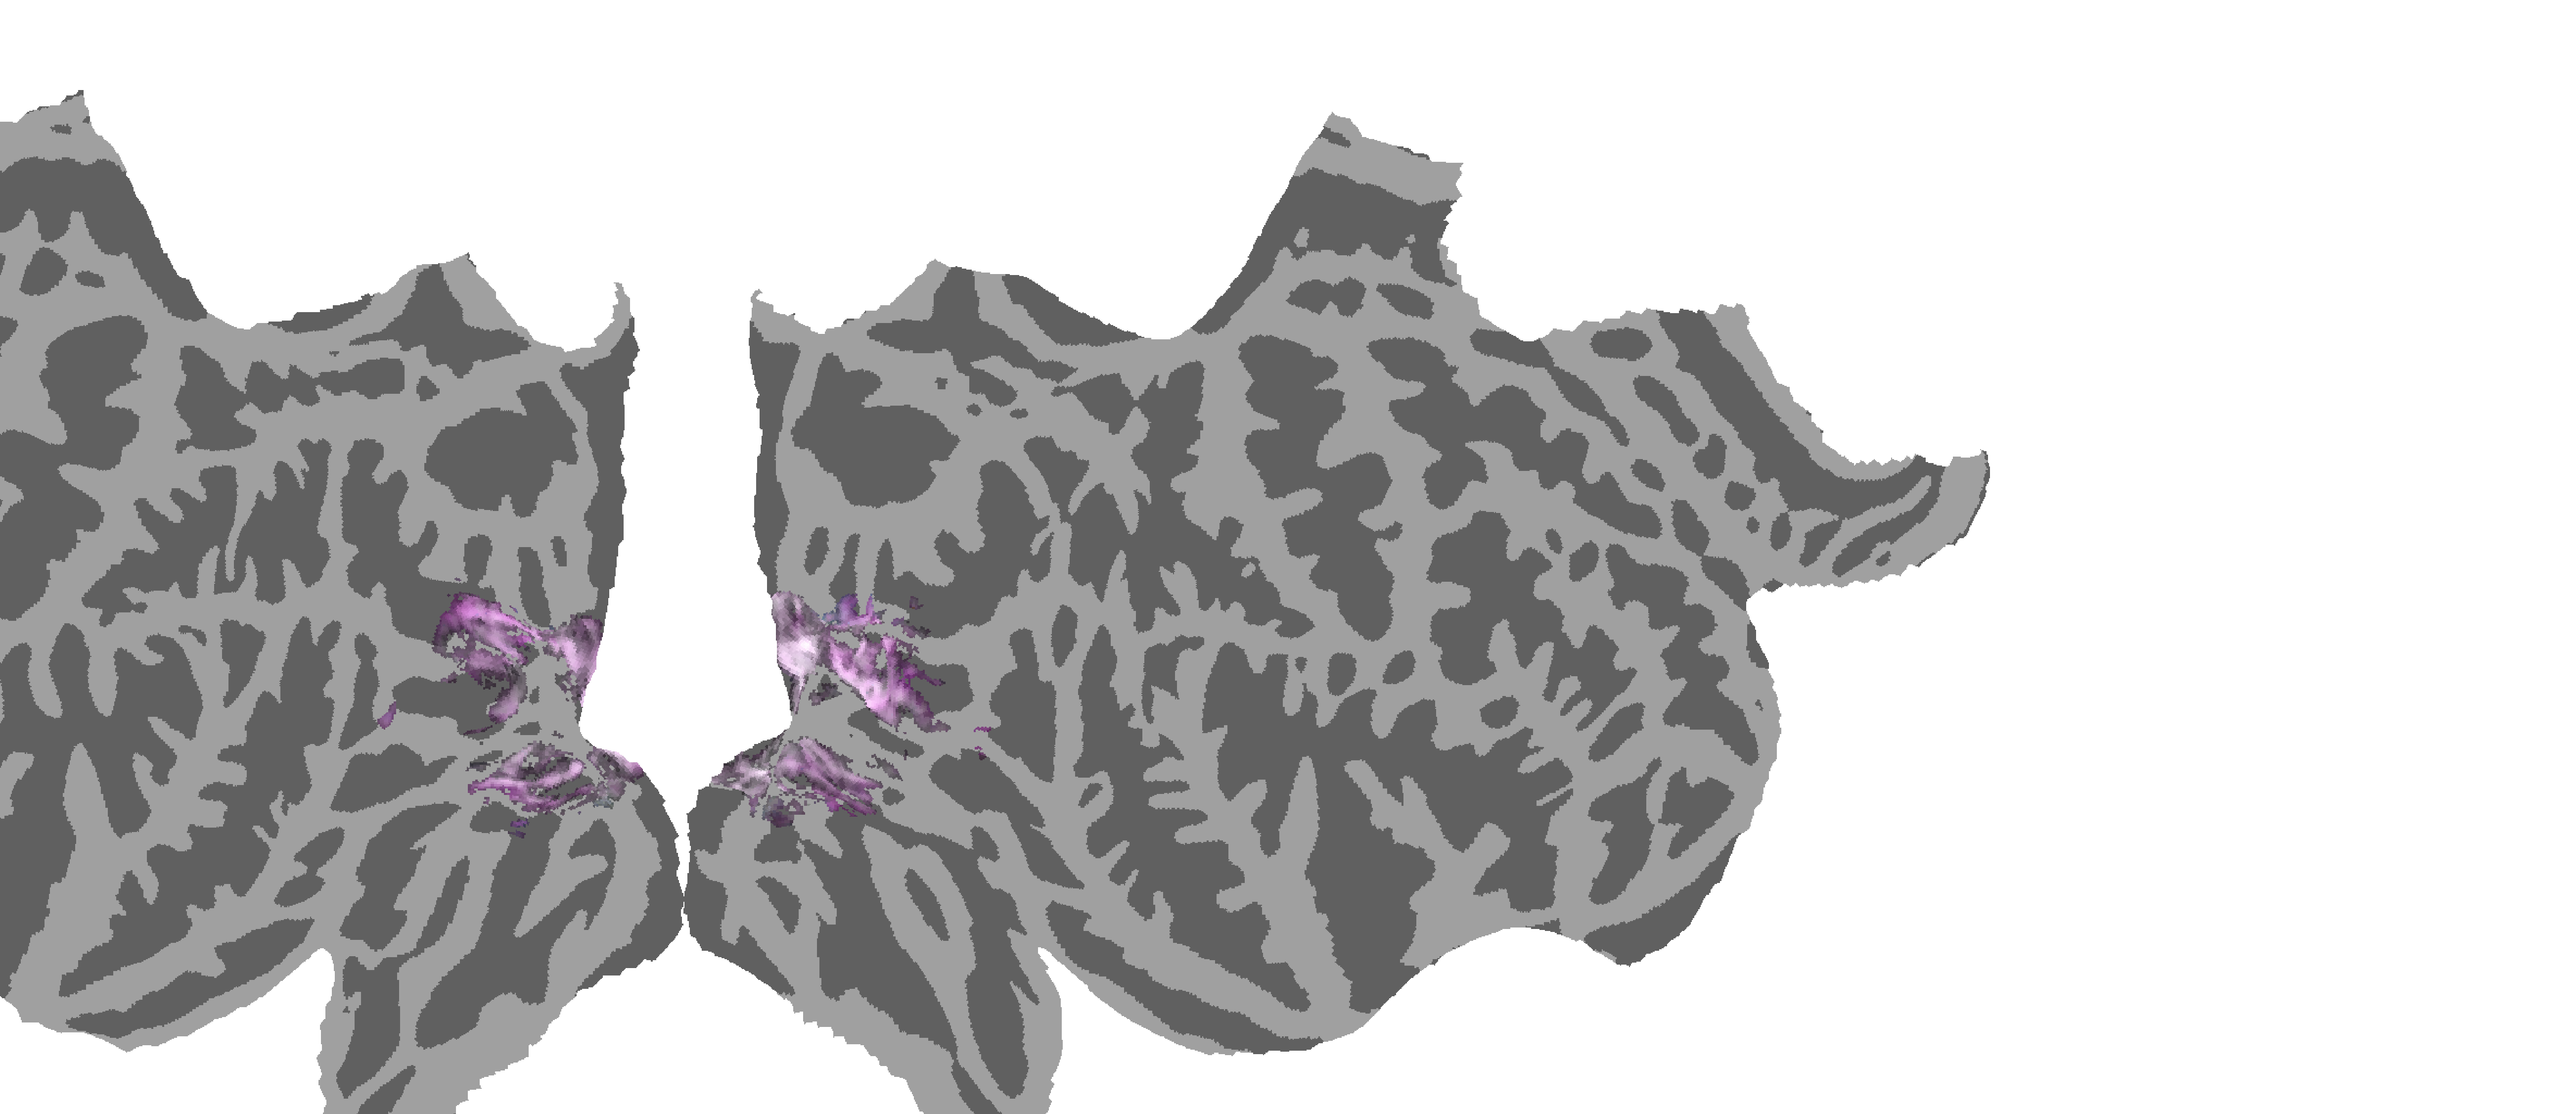

In [83]:
%matplotlib notebook
pl.ioff()
cortex.quickshow(models_rsq_vertex_data, 
                 with_curvature=True, 
                 with_labels=False, 
                 with_rois=False, 
                 with_borders=False, 
                 with_colorbar=False)

In [212]:
import nibabel as nb
darrays = [nb.gifti.gifti.GiftiDataArray(d) for d in res_R.T]
gii_in_R = nb.load(opj(data_path, 'fmriprep/'+subj+'/ses-1/func/'+subj+'_ses-1_task-'+task_name+'_run-1_space-'+fitting_space+'_hemi-R.func.gii'))

gii_out = nb.gifti.gifti.GiftiImage(header=gii_in_R.header, 
                            extra=gii_in_R.extra,
                            darrays=darrays)

out_name = '/Users/marcoaqil/PRFMapping/sub-001_norm-iterparams_space-fsaverage_hemi-R-attempt.gii'
nb.save(gii_out, out_name)

In [208]:
darrays = [nb.gifti.gifti.GiftiDataArray(d) for d in res_R.T]
print(gii_in_R.darrays[0].data.shape)
print(darrays[0].data.shape)

(163842,)
(163842,)


In [5]:
# MODEL COMPARISON

In [88]:
# grid params
grid_nr = 20
max_ecc_size = prf_stim.max_ecc
sizes, eccs, polars = max_ecc_size * np.linspace(0.25, 1, grid_nr)**2, \
    max_ecc_size * np.linspace(0.1, 1, grid_nr)**2, \
    np.linspace(0, 2*np.pi, grid_nr)


# to avoid dividing by zero
inf = np.inf
eps = 1e-1
ss = prf_stim.screen_size_degrees

# Gaussian model
gg = Iso2DGaussianGridder(stimulus=prf_stim,
                          hrf=hrf,
                          filter_predictions=True,
                          window_length=window_length,
                          task_lengths=task_lengths)


gf = Iso2DGaussianFitter(
    data=tc_full_iso_nonzerovar_dict['tc'], gridder=gg, n_jobs=n_jobs,
    bounds=[(-10*ss, 10*ss),  # x
            (-10*ss, 10*ss),  # y
            (eps, 10*ss),  # prf size
            (-inf, +inf),  # prf amplitude
            (0, +inf)],  # bold baseline
    gradient_method=gradient_method)

In [90]:
# gaussian grid fit
if grid_data_path == None:
    gf.grid_fit(ecc_grid=eccs,
                polar_grid=polars,
                size_grid=sizes)
else:
    gf.gridsearch_params = np.load(grid_data_path)

[autoreload of prfpy.fit failed: Traceback (most recent call last):
  File "/Users/marcoaqil/anaconda3/envs/prfpy/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/marcoaqil/anaconda3/envs/prfpy/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/marcoaqil/anaconda3/envs/prfpy/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/Users/marcoaqil/anaconda3/envs/prfpy/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/Users/marcoaqil/anaconda3/envs/prfpy/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_instances
    update_instances(old, new, obj, visited)
  File "/Users/marcoaqil/anaconda3/envs/prfpy/lib/python3.7/site-packages/IPython/ex

AttributeError: 'Iso2DGaussianFitter' object has no attribute 'verbose'

In [8]:
# gaussian iterative fit

gf.iterative_fit(rsq_threshold=rsq_threshold, verbose=verbose)


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:  1.1min
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:  5.6min
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed: 13.9min
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed: 24.8min
[Parallel(n_jobs=11)]: Done 1228 tasks      | elapsed: 39.1min
[Parallel(n_jobs=11)]: Done 1778 tasks      | elapsed: 56.9min
[Parallel(n_jobs=11)]: Done 2428 tasks      | elapsed: 78.0min
[Parallel(n_jobs=11)]: Done 3178 tasks      | elapsed: 101.9min
[Parallel(n_jobs=11)]: Done 4028 tasks      | elapsed: 129.3min
[Parallel(n_jobs=11)]: Done 4978 tasks      | elapsed: 159.9min
[Parallel(n_jobs=11)]: Done 6028 tasks      | elapsed: 195.8min
[Parallel(n_jobs=11)]: Done 7178 tasks      | elapsed: 234.5min
[Parallel(n_jobs=11)]: Done 8428 tasks      | elapsed: 277.5min
[Parallel(n_jobs=11)]: Done 9778 tasks      | elapsed: 323.5min
[Parallel(n_jobs=11)]: Done 11228 task

In [9]:
#gridsearch_params always contains the CSS exponent parameter, even if it is not fit.
#whereas iterative_search_params does not contain it if it is not fit)
starting_params = np.insert(gf.iterative_search_params, -1, 1.0, axis=-1)
#starting_params = np.load('/Users/marcoaqil/PRFMapping/iterated_gauss_fsaverage.npy')

In [10]:
# difference of gaussians iterative fit

gg_dog = DoG_Iso2DGaussianGridder(stimulus=prf_stim,
                                  hrf=hrf,
                                  filter_predictions=True,
                                  window_length=window_length,
                                  task_lengths=task_lengths)

gf_dog = DoG_Iso2DGaussianFitter(data=tc_full_iso_nonzerovar_dict['tc'],
                                 gridder=gg_dog,
                                 n_jobs=n_jobs,
                                 bounds=[(-10*ss, 10*ss),  # x
                                         (-10*ss, 10*ss),  # y
                                         (eps, 10*ss),  # prf size
                                         (-inf, +inf),  # prf amplitude
                                         (0, +inf),  # bold baseline
                                         (-inf, +inf),  # surround amplitude
                                         (eps, 20*ss)],  # surround size
                                 gradient_method=gradient_method)

gf_dog.iterative_fit(rsq_threshold=0.4,
                     gridsearch_params=starting_params, verbose=verbose)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:  5.0min
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed: 30.2min
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed: 72.0min
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed: 124.8min
[Parallel(n_jobs=11)]: Done 1228 tasks      | elapsed: 195.1min
[Parallel(n_jobs=11)]: Done 1778 tasks      | elapsed: 287.2min
[Parallel(n_jobs=11)]: Done 2428 tasks      | elapsed: 389.7min
[Parallel(n_jobs=11)]: Done 3178 tasks      | elapsed: 513.9min
[Parallel(n_jobs=11)]: Done 4028 tasks      | elapsed: 650.0min
[Parallel(n_jobs=11)]: Done 4978 tasks      | elapsed: 811.7min
[Parallel(n_jobs=11)]: Done 5924 out of 5924 | elapsed: 966.7min finished


In [11]:
# CSS iterative fit

gf_css = Iso2DGaussianFitter(
    data=tc_full_iso_nonzerovar_dict['tc'], gridder=gg, n_jobs=n_jobs, fit_css=True,
    bounds=[(-10*ss, 10*ss),  # x
            (-10*ss, 10*ss),  # y
            (eps, 10*ss),  # prf size
            (-inf, +inf),  # prf amplitude
            (0, +inf),  # bold baseline
            (0.001, 3)],  # CSS exponent
    gradient_method=gradient_method)

gf_css.iterative_fit(rsq_threshold=0.4,
                     gridsearch_params=starting_params, verbose=verbose)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed:  8.8min
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed: 21.1min
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed: 38.2min
[Parallel(n_jobs=11)]: Done 1228 tasks      | elapsed: 60.3min
[Parallel(n_jobs=11)]: Done 1778 tasks      | elapsed: 86.8min
[Parallel(n_jobs=11)]: Done 2428 tasks      | elapsed: 118.6min
[Parallel(n_jobs=11)]: Done 3178 tasks      | elapsed: 155.4min
[Parallel(n_jobs=11)]: Done 4028 tasks      | elapsed: 197.2min
[Parallel(n_jobs=11)]: Done 4978 tasks      | elapsed: 242.4min
[Parallel(n_jobs=11)]: Done 5924 out of 5924 | elapsed: 288.6min finished


In [12]:
# normalization iterative fit
gg_norm = Norm_Iso2DGaussianGridder(stimulus=prf_stim,
                                    hrf=hrf,
                                    filter_predictions=True,
                                    window_length=window_length,
                                    task_lengths=task_lengths)

gf_norm = Norm_Iso2DGaussianFitter(data=tc_full_iso_nonzerovar_dict['tc'],
                                   gridder=gg_norm,
                                   n_jobs=n_jobs,
                                   bounds=[(-10*ss, 10*ss),  # x
                                           (-10*ss, 10*ss),  # y
                                           (eps, 10*ss),  # prf size
                                           (-inf, +inf),  # prf amplitude
                                           (0, +inf),  # bold baseline
                                           (-inf, +inf),  # neural baseline
                                           (-inf, +inf),  # surround amplitude
                                           (eps, 20*ss),  # surround size
                                           (-inf, +inf)],  # surround baseline
                                   gradient_method=gradient_method)

gf_norm.iterative_fit(rsq_threshold=0.4,
                      gridsearch_params=starting_params, verbose=verbose)

[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:  8.5min
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed: 56.9min
[Parallel(n_jobs=11)]: Done 428 tasks      | elapsed: 138.9min
[Parallel(n_jobs=11)]: Done 778 tasks      | elapsed: 254.7min
[Parallel(n_jobs=11)]: Done 1228 tasks      | elapsed: 396.9min
[Parallel(n_jobs=11)]: Done 1778 tasks      | elapsed: 570.2min
[Parallel(n_jobs=11)]: Done 2428 tasks      | elapsed: 781.0min
[Parallel(n_jobs=11)]: Done 3178 tasks      | elapsed: 1026.5min
[Parallel(n_jobs=11)]: Done 4028 tasks      | elapsed: 1280.3min
[Parallel(n_jobs=11)]: Done 4978 tasks      | elapsed: 1588.6min
[Parallel(n_jobs=11)]: Done 5924 out of 5924 | elapsed: 1901.5min finished


In [17]:
print("gauss grid rsq: "+str(gf.gridsearch_params[gf_css.rsq_mask, -1].mean()))
print("gauss iter rsq: "+str(gf.iterative_search_params[gf_css.rsq_mask, -1].mean()))
print("css iter rsq: "+str(gf_css.iterative_search_params[gf_css.rsq_mask, -1].mean()))
print("dog iter rsq: "+str(gf_dog.iterative_search_params[gf_dog.rsq_mask, -1].mean()))
print("norm iter rsq: "+str(gf_norm.iterative_search_params[gf_norm.rsq_mask, -1].mean()))

gauss grid rsq: 0.5283278842418279
gauss iter rsq: 0.5364675907041455
css iter rsq: 0.6016873876717737
dog iter rsq: 0.5420141200397566
norm iter rsq: 0.6036119283624145


In [18]:
vox= np.argmax(gf_dog.iterative_search_params[gf_css.rsq_mask, -1] - gf_norm.iterative_search_params[gf_css.rsq_mask, -1])

In [60]:
print(gf_dog.iterative_search_params[gf_css.rsq_mask,:][vox,:])
print(gf_norm.iterative_search_params[gf_css.rsq_mask,:][vox,:])

[ 1.64470250e+01 -1.31557453e+01  4.96540928e+00  1.16041123e+04
  6.96954876e+04  2.94387905e+01  1.17805600e+01  5.26950043e-01]
[ 2.20954215e+01 -1.72536325e+01  3.96313731e+00  1.15665412e+04
  6.94480590e+04 -8.21211108e-05  1.00000000e+00  1.00000000e+00
  8.61804525e-06  4.46154993e-01]


In [157]:
gauss_vox = gf.iterative_search_params[gf_css.rsq_mask,:][vox,:]
dog_vox = gf_dog.iterative_search_params[gf_css.rsq_mask,:][vox,:]
norm_vox = gf_norm.iterative_search_params[gf_css.rsq_mask,:][vox,:]

#norm_vox[:4] = dog_vox[:4]

#norm_vox[3]*=40
#norm_vox[4]-=1000
#norm_vox[5] = 1000
#norm_vox[6] = 1
#norm_vox[7] = 1.17805600e+01
#norm_vox[8] = 1

norm_vox[:5] = gauss_vox[:5]
norm_vox[5] = 1000
norm_vox[6] = 1
norm_vox[7] = 21
norm_vox[8] = 1


norm_vox

array([ 1.05525257e+01, -8.20748583e+00,  2.59246865e+00,  1.15665413e+04,
        6.94481622e+04,  1.00000000e+03,  1.00000000e+00,  2.10000000e+01,
        1.00000000e+00,  4.46154993e-01])

<IPython.core.display.Javascript object>


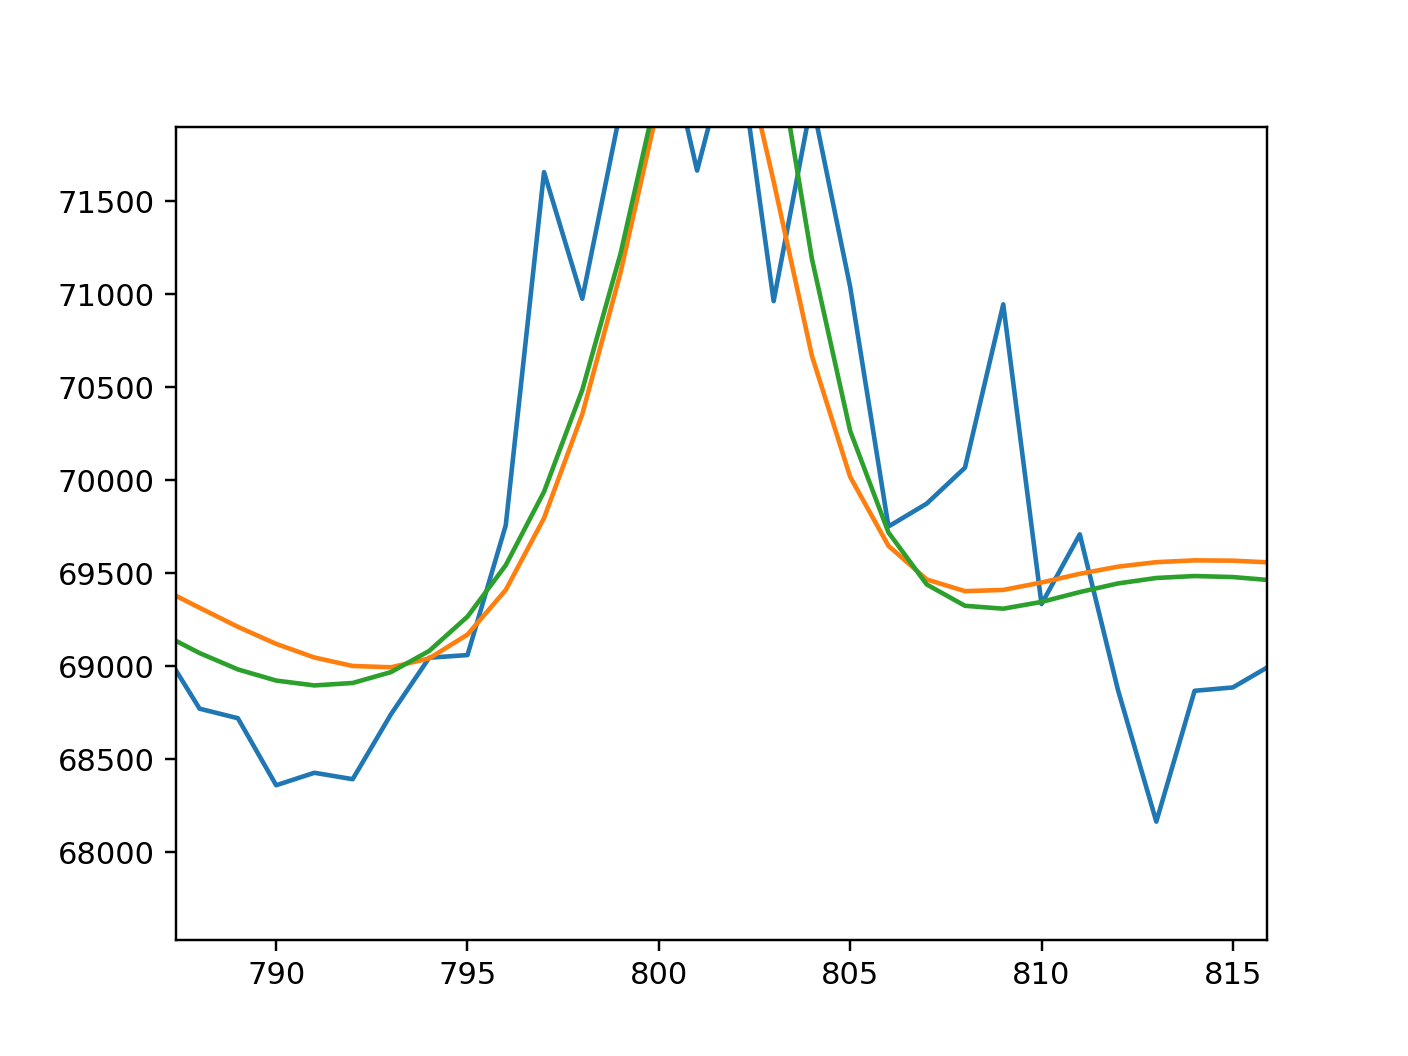

In [163]:
%matplotlib notebook
fig=pl.figure()
pl.plot(tc_full_iso_nonzerovar_dict['tc'][gf_css.rsq_mask,:][vox])
#pl.plot(gg_norm.return_single_prediction(*list(current_result[np.where(gridsearch_params[:,-1]>0.66),:][0,vox,:-1])))
#pl.plot(gg_norm.return_single_prediction(*list(norm_vox[:-1])))
pl.plot(gg_dog.return_single_prediction(*list(dog_vox[:-1])))
pl.plot(gg_norm.return_single_prediction(*list(res[:-1])))


<IPython.core.display.Javascript object>


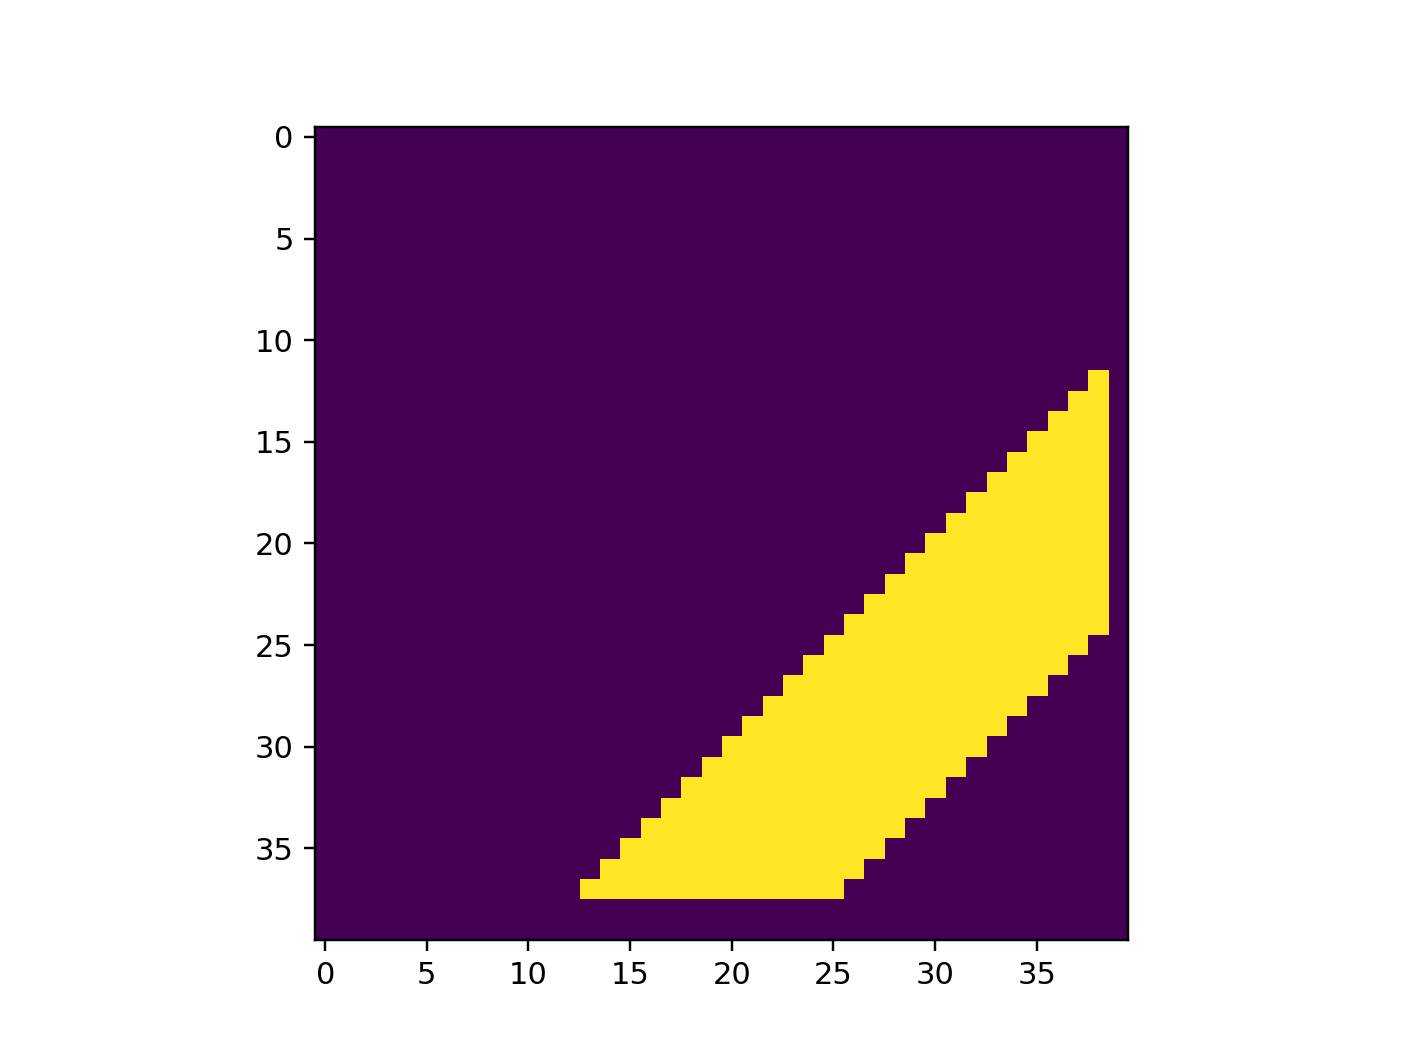

(40, 40, 1180)

In [9]:
%matplotlib notebook
pl.figure()
pl.imshow(prf_stim.design_matrix[:,:,907])
prf_stim.design_matrix.shape

In [158]:
from prfpy.fit import iterative_search


res_2 = iterative_search(gg_norm,
                       tc_full_iso_nonzerovar_dict['tc'][gf_css.rsq_mask,:][vox],
                      norm_vox[:-1],
                       args={},
                       verbose=False,
                       bounds=[(-10*ss, 10*ss),  # x
                                           (-10*ss, 10*ss),  # y
                                           (eps, 10*ss),  # prf size
                                           (-inf, +inf),  # prf amplitude
                                           (0, +inf),  # bold baseline
                                           (-inf, +inf),  # neural baseline
                                           (-inf, +inf),  # surround amplitude
                                           (eps, 20*ss),  # surround size
                                           (-inf, +inf)],  # surround baseline
                       gradient_method='numerical')

In [159]:
res_2

array([ 1.40547567e+01, -1.09372662e+01,  4.45060011e+00,  1.15665624e+04,
        6.86471350e+04,  9.97045733e+02,  1.63253189e-02,  1.79210614e+02,
        1.00500228e+00,  5.87074264e-01])

In [160]:
res

array([ 2.08896939e+01, -1.65670767e+01,  5.56723078e+00,  4.64163001e+05,
        6.80982881e+04,  1.00495810e+03,  2.67712106e-01,  1.05361546e+01,
        6.58730724e-01,  6.01562680e-01])

<IPython.core.display.Javascript object>


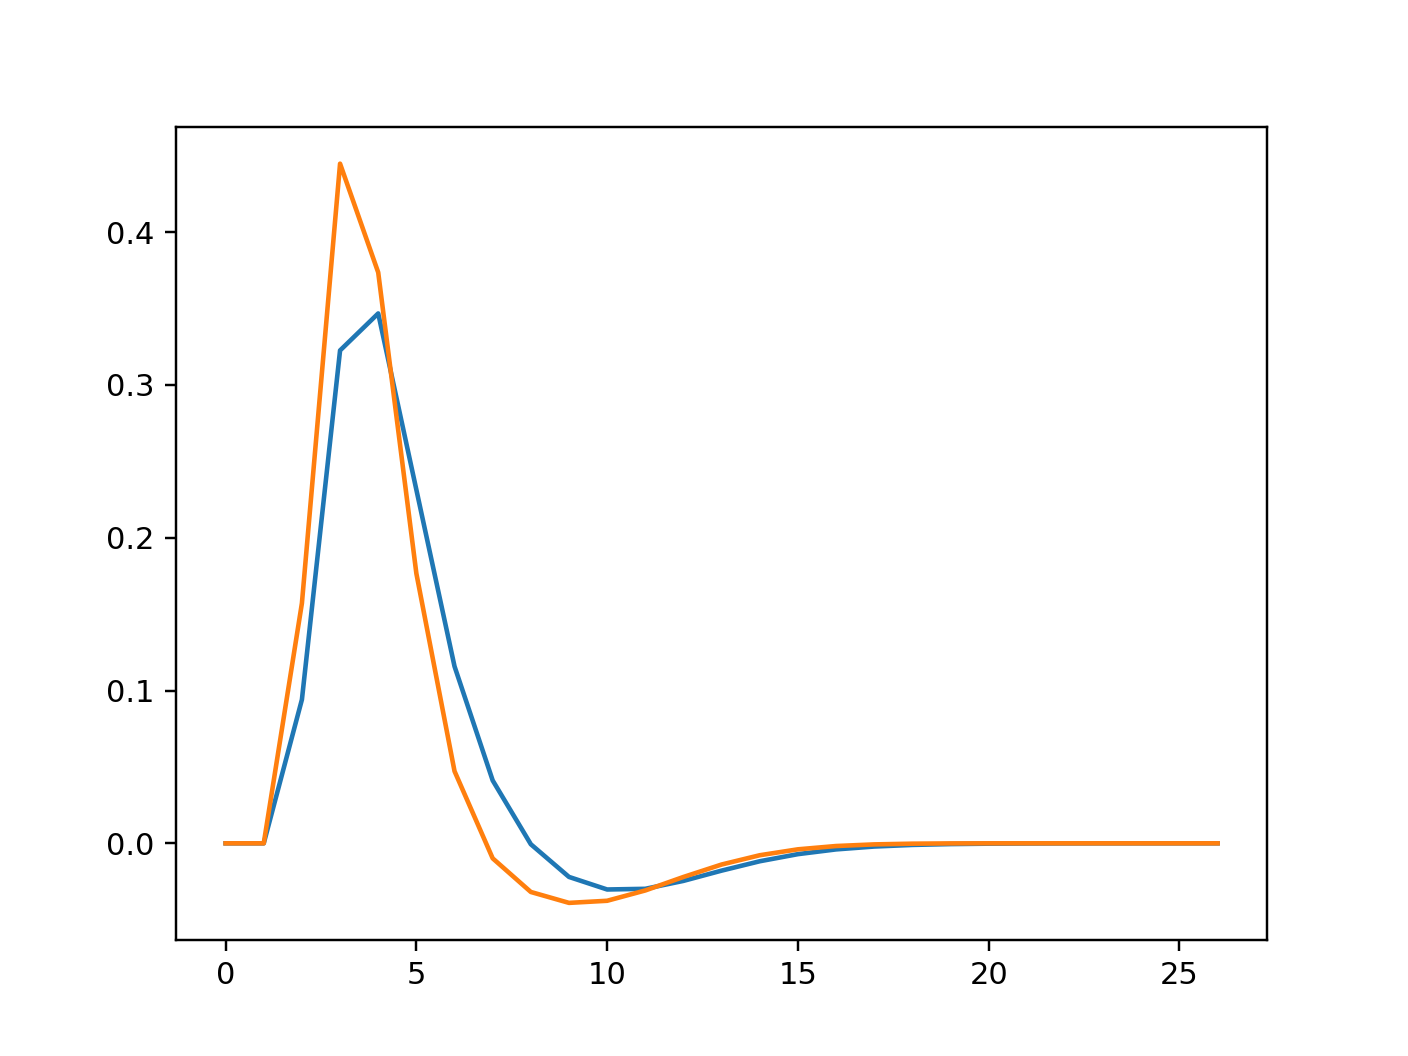

In [176]:
pl.figure()
from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative

hrf=[1,2,0]
hrf = np.array([hrf[0] * spm_hrf(tr=1.5,
                                                  oversampling=1, time_length=40),
                                 hrf[1] * spm_time_derivative(tr=1.5,
                                                              oversampling=1, time_length=40),
                                 hrf[2] * spm_dispersion_derivative(tr=1.5,
                                                                    oversampling=1, time_length=40)]).sum(axis=0)
pl.plot(gg_norm.hrf)
pl.plot(hrf)